# Topic extraction from the GEPRiS dataset and creation of an user-centric visualisation
Author: Tim Korjakow        
Summer term 2018      
Freie Universität Berlin     
Fachgebiet Human-Centered Computing

![Process graph](nlpflowchart.svg)

In [13]:
%load_ext autoreload
%autoreload 2
from sklearn.metrics import silhouette_samples
from sklearn.pipeline import Pipeline
import numpy as np
import json
from scipy.stats import entropy
import bz2
import csv
from bokeh.palettes import d3

from Preprocessing.preprocessing import Preprocessing
from Embedding.embedding import Embedding
from Topicextraction.topicextraction import TopicExtraction
from Clustering.clustering import Clustering
from Planereduction.planereduction import PlaneReduction
from Linearization.linearization import mapToSpaceSampling, computeClusterTopography
from Debug.debug import Debug
from sklearn.manifold import MDS
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import graph_shortest_path
from sklearn.neighbors import NearestNeighbors, kneighbors_graph


# interactivity
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, Dropdown, FloatSlider, fixed
import ipywidgets as widgets
from IPython.display import display, Javascript, HTML
import pickle


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
models = {
#	'Doc2Vec': Embedding(method='Doc2Vec', model_path='../../../assets/models/doc2vec/doc2vec.joblib'),
#	'TfIdf': Embedding(method='TfIdf', dict_path='../../../assets/models/dict/dict.joblib', model_path='../../../assets/models/tfidf/tfidf.joblib'),
	'ATM': Embedding(method='ATM', dict_path='../models/dict/dict.joblib', model_path='../models/atm/atm.joblib')
}

print('Finished loading')

Finished loading


In [3]:
models["ATM"].selector.transform(1).shape

from sklearn.neighbors import NearestNeighbors

In [4]:
for topic in models["ATM"].selector.model.show_topics(num_topics=10):
    #print('Label: ' + topic_labels[topic[0]])
    words = ''
    for word, prob in models["ATM"].selector.model.show_topic(topic[0]):
        words += word + ' '
    print('Words: ' + words)
    print()

Words: Lästigkeit Produktentwicklungsphasen microphone Schädigungsmodelle Konstruktionswerkstoffen Substratmaterialien Wiedergabesystems Festkörperkontakt bspw auralization 

Words: nicotine schizophren Routineversorgung sleep attentional Horizontalzellen Herzfrequenzvariabilität Fovea Frühgeburt CASK 

Words: Werkstück Leichtbau Aluminiumlegierungen Drehzahl Kaltgasspritzen Prozesssicherheit Einsatzbedingungen Sprachverständlichkeit Audioqualität Fließspannung 

Words: Stählen Superlegierungen Duktilität Korrosionsbeständigkeit tribologische Legierungselemente Ermüdungseigenschaften Fügen Werkstoffverhalten Schädigungsentwicklung 

Words: Podozyten EGFR spermatogenesis Thrombozyten Fibrose ncRNAs pancreatic myeloid aureus glomerulären 

Words: Nitrosoverbindungen Vergiftung Ionischen Ruthenium syntheses itch Base Iridium Colletotrichum Einlagerung 

Words: Treg kardiale Astrozyten Schlaf Spermatogenese renalen Präeklampsie myokardialen Plazenta Niereninsuffizienz 

Words: peripher act

In [20]:
pipe = Pipeline([('Embedding', models['ATM']),
                 ('EmbeddingData', Debug()),
                 ('PlaneReduction', PlaneReduction(2, method='TSNE', perplexity=6, metric=jensenshannon))], verbose=True)

tfs_plane, labels = pipe.fit_transform(np.ones((10,10)))

# compute linearization
tfs_mapped = mapToSpaceSampling(tfs_plane)

# compute cluster topography
uncertainty = entropy(np.array(pipe.named_steps.EmbeddingData.data[0]).T + 0.000001)

nbrs_ = NearestNeighbors(n_neighbors=6,metric=jensenshannon, n_jobs=-1)
nbrs_.fit(pipe.named_steps.EmbeddingData.data[0])

kng = kneighbors_graph(nbrs_, 6, metric=jensenshannon, mode='distance', n_jobs=-1)

dist_matrix_ = graph_shortest_path.graph_shortest_path(kng, directed=False)

interpolated_topography = computeClusterTopography(tfs_mapped, uncertainty, 600, 600, 'cubic')
dump = {
            'project_data': [{'mappoint':mappoint, 'embpoint':embpoint, 'cluster':cluster, 'entropy': entropy, 'title':title, 'doc_count':doc_count} for mappoint, embpoint, cluster, entropy, title, doc_count in zip(
                tfs_mapped.tolist(),
                tfs_plane.tolist(),
                LabelEncoder().fit_transform([x[2] for x in models["ATM"].selector.model.doc2author.values()]).tolist(),
                uncertainty.tolist(),
                list(models["ATM"].selector.model.id2author.values()),
                [len(models["ATM"].selector.model.author2doc[author]) for author in models["ATM"].selector.model.id2author.values()]
            )],
            'cluster_data': {
                'cluster_colour': d3['Category20'][4]
            },
            'cluster_topography': np.flip(interpolated_topography.T, axis=0).flatten().tolist(),
            'dist_matrix': dist_matrix_.tolist(),
            'topography_width': 600,
            'topography_height': 600
        }

[Pipeline] ......... (step 1 of 3) Processing Embedding, total=   0.0s
[Pipeline] ..... (step 2 of 3) Processing EmbeddingData, total=   0.0s
[Pipeline] .... (step 3 of 3) Processing PlaneReduction, total=   3.3s


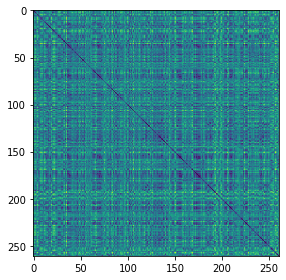

In [29]:
import matplotlib
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
im = ax.imshow(dist_matrix_)
fig.tight_layout()
plt.show()


In [21]:
def draw_scatter(data, width=600, height=600, viz='linearized'):
    display(Javascript("""
        (function(element){
            require(['scatter'], function(scatter) {
                scatter(element.get(0), %s, %d, %d, %s);
            });
        })(element);
    """ % (json.dumps(data), width, height, json.dumps(viz))))

In [22]:
def visualize(dump=None):
    # viz dimensions
    width = 600
    height = 600

    display(HTML(filename="scatter.css.html"))
    display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
    display(Javascript(filename="scatter.js"))
    draw_scatter(dump, width, height)
    with open('./dump.json', 'w+') as f:
        json.dump(dump, f)

In [23]:
w = interactive(visualize, dump=fixed(dump))
display(w)


interactive(children=(Output(),), _dom_classes=('widget-interact',))